## **Graph Neural Networks for Capturing Dependencies in Graph Structured Data (Part 2/2)**

In [1]:
from IPython.display import Image
%matplotlib inline

### **Implementing a GNN using the PyTorch Geometric library**

- Implement `GNN` using the PyTorch Geometric library, which simplifies the process of training `GNNs`.

- We apply the `GNN` to `QM9`, a dataset consisting of small molecules, to predict isotropic polarizability, which is a measure of a molecule’s tendency to have its charge distorted by an electric field.

In [5]:
import torch
from torch_scatter import scatter
import torch_geometric

print(torch.__version__)
print(torch_geometric.__version__)
print("MPS available:", torch.backends.mps.is_available())


2.3.1
2.6.1
MPS available: True


- Let’s start by loading a dataset of small molecules and look at how PyTorch Geometric stores the data:

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

- Let's load the `QM9` small molecule dataset

In [7]:
dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

- Here's how torch geometric wraps data

In [8]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

- can access attributes directly

In [9]:
data.z

tensor([6, 1, 1, 1, 1])

In [11]:
data.pos

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

In [12]:
data.y

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

- the atomic number of each atom can add attributes

In [13]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

- can move all attributes between devices

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
data.to(device)

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [17]:
data.x.is_cuda, data.x.device      

(False, device(type='mps', index=0))

The Data object is a convenient, flexible wrapper for graph data. Note that many PyTorch Geometric objects require certain keywords in data objects to process them correctly. Specifically, $x$ should contain node features, `edge_attr` should contain edge features, `edge_index` should include an edge
list, and $y$ should contain labels. The `QM9` data contains some additional attributes of note: `pos`, the position of each of the molecules’ atoms in a 3D grid, and $z$, the atomic number of each atom in the molecule. The labels in the `QM9` are a bunch of physical properties of the molecules, such as dipole
moment, free energy, enthalpy, or isotropic polarization. We are going to implement a `GNN` and train it on `QM9` to predict isotropic polarization.

**The QM9 dataset**

The `QM9` dataset contains `133,885` small organic molecules labeled with several geometric, energetic, electronic, and thermodynamic properties. `QM9` is a common benchmark dataset for developing methods for predicting chemical structure-property relationships and hybrid quantum mechanic/machine learning methods.


- Via the following code, we implement a `GNN` utilizing two such graph convolutional layers (NNConv):

In [20]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

- We’ll train this `GNN` to predict a molecule’s isotropic polarizability, a measure of the relative tendency of a molecule’s charge distribution to be distorted by an external electric field. We’ll split the `QM9` dataset into training, validation, and test sets, and use PyTorch Geometric DataLoader. Note that these do not require a special collate function, but require a Data object with appropriately named attributes.


**Next, let’s split the dataset:**

In [18]:
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

**The following code will initialize and train a network on a GPU (if available):**

In [21]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [22]:
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

- computing the `mean squared error (MSE)` loss instead of the cross-entropy, since polarizability is a continuous target and not a class label:

In [23]:
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.54 | validation avg. loss: 0.30
Epochs: 1 | epoch avg. loss: 0.16 | validation avg. loss: 0.09
Epochs: 2 | epoch avg. loss: 0.12 | validation avg. loss: 0.12
Epochs: 3 | epoch avg. loss: 0.11 | validation avg. loss: 0.09


- Over the first four training epochs, both training and validation loss are decreasing.
- The following code predicts the values on the test data and collects the true labels:

In [24]:
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

- Now we can make a scatterplot with a subset of the test data. Since the test dataset is relatively large `(10,000 molecules)`, the results can be a bit cluttered, and for simplicity, we only plot the first `500` predictions and targets:

Text(0.5, 0, 'Isotropic polarizability')

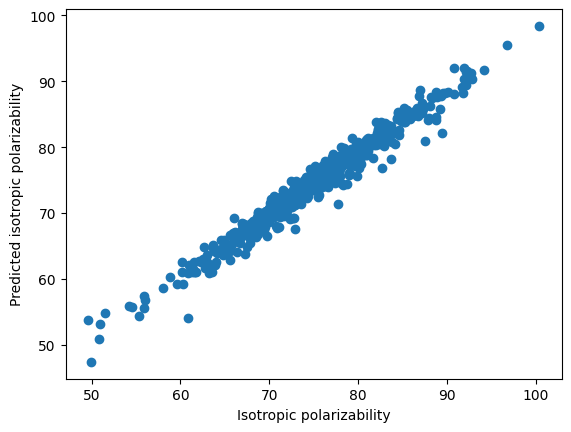

In [25]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)

- Based on the plot, given that the points lie relatively near the diagonal, our simple GNN appears to have done a decent job with predicting isotropic polarization values, even without hyperparameter tuning.

**PyTorch Geometric is a comprehensive general-purpose library for working with graphs, including molecules**

### **Other GNN layers and recent developments**



#### **Spectral graph convolutions**

The graph convolutions we have utilized up to this point have all been spatial in nature. This means that they aggregate information based on the topological space associated with the graph, which is just a fancy way of saying that spatial convolutions operate on local neighborhoods of nodes. As a consequence of this, if a GNN that utilizes spatial convolutions needs to capture complex global patterns in graph data, then the network will need to stack multiple spatial convolutions. In situations where these global patterns are important, but network depth needs to be limited, spectral graph convolutions are an alternative kind of convolution to consider.


Spectral graph convolutions operate differently than spatial graph convolutions. Spectral graph convolutions operate by utilizing the graph’s spectrum—its set of eigenvalues—by computing the eigendecomposition of a normalized version of the graph’s adjacency matrix called the graph Laplacian. 


For an undirected graph, the Laplacian matrix of a graph is defined as $L = D – A$, where `A` is the adjacency matrix of the graph and `D` is the degree matrix. A degree matrix is a diagonal matrix where the element on the diagonal in the row with index i is the number of edges in and out of the node associated with the ith row of the adjacency matrix.

#### **Pooling**

Pooling layers for image data (ab)use spatial locality, which graphs do not have. If a clustering of the nodes in a graph is provided, we can define how a graph pooling layer should pool nodes. However, it is unclear how to define optimal clustering, and different clustering approaches may be favored for
different contexts. Even after clustering is determined, if nodes are downsampled, it is unclear how the remaining nodes should be connected. While these are still open research questions, we’ll look at a few graph pooling layers and point out their approaches to the aforementioned issues.


![Applying max pooling to a graph](./figures/18_13.png)


Each cluster’s embedding is equal to the mean or max of the embeddings of the nodes in the cluster. To address connectivity, the cluster is assigned the union of all edge indices in the cluster.

#### **Normalization**

Normalization techniques are utilized in many kinds of neural networks to help stabilize and/or speed up the training process.

**GraphNorm**

GraphNorm is a normalization technique designed specifically for graph neural networks (GNNs). Unlike BatchNorm or LayerNorm, which standardize features across batches or feature dimensions, GraphNorm normalizes node features *within each individual graph*. This is essential because graphs in a batch may vary significantly in size and distribution.



**Core Idea**

For a graph ( G ) with node features $( x_i \in \mathbb{R}^d )$:

1. Compute the mean of node features within the graph:
   $`\mu_G = \frac{1}{|G|} \sum_{i \in G} x_i`$

2. Compute the standard deviation within the graph:
   $` \sigma_G = \sqrt{\frac{1}{|G|} \sum_{i \in G} (x_i - \mu_G)^2 + \epsilon }`$

3. Normalize node features:
   $`\hat{x}_i = \frac{x_i - \mu_G}{\sigma_G}`$

4. Learnable affine parameters rescale and shift:
   $`y_i = \gamma \cdot \hat{x}_i + \beta`$



**Why GraphNorm Matters**

| Normalization | Normalizes Over             | Suitable For                              | Limitation in GNN Context                               |
| ------------- | --------------------------- | ----------------------------------------- | ------------------------------------------------------- |
| **BatchNorm** | Batch dimension             | Vision/standard deep models               | Graphs in a batch have variable sizes and distributions |
| **LayerNorm** | Feature dimension           | NLP, transformers                         | Does not account for per-graph variation                |
| **GraphNorm** | **Nodes within each graph** | **Any GNN with variable graph structure** | Slight additional compute per graph                     |

GraphNorm stabilizes training and reduces variance arising from heterogeneous graph structures.



**Key Benefits**

* Improves convergence in deep GNNs.
* Handles differing graph scales more effectively.
* Often leads to better performance on graph classification and regression tasks.


---